***
## <font color=red>Anomaly/Outlier Detection Model with PyOD </font>
<p style="margin-left:3%; margin-right:10%;"><font color=teal> L. Saetta   07/2021</font></p>

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.iforest import IForest

sns.set(color_codes=True)
%matplotlib inline

### Step 2: load from the single datafile

In [2]:
RESULT_FILE_NAME = "BearingsNasaTest1.csv"

# Step 2: legge i dati da file
result_data = pd.read_csv(RESULT_FILE_NAME, index_col = 0)

# attenzione, il formato della data è cambiato
result_data.index = pd.to_datetime(result_data.index, format='%Y-%m-%d %H:%M:%S')
result_data = result_data.sort_index()

In [3]:
result_data.head()

,Br11,Br12,Br21,Br22,Br31,Br32,Br41,Br42
2003-10-22 12:06:24,0.1041,0.1003,0.1071,0.1020,0.1061,0.1082,0.0948,0.0995
2003-10-22 12:09:13,0.1037,0.0999,0.1082,0.1029,0.1067,0.1085,0.0951,0.0936
2003-10-22 12:14:13,0.1050,0.1015,0.1085,0.1040,0.1087,0.1099,0.0962,0.0983
2003-10-22 12:19:13,0.1049,0.1016,0.1082,0.1034,0.1081,0.1100,0.0968,0.0986
2003-10-22 12:24:13,0.1048,0.1022,0.1079,0.1026,0.1085,0.1093,0.0964,0.0985


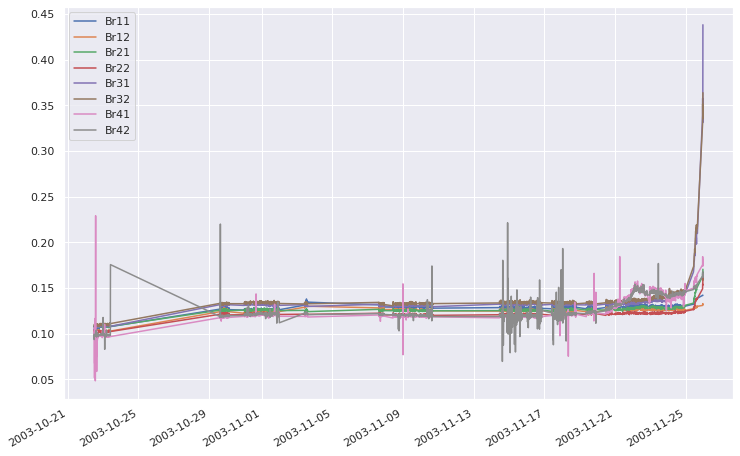

In [5]:
# plot all data
result_data.plot(figsize = (12,8));

<AxesSubplot:>

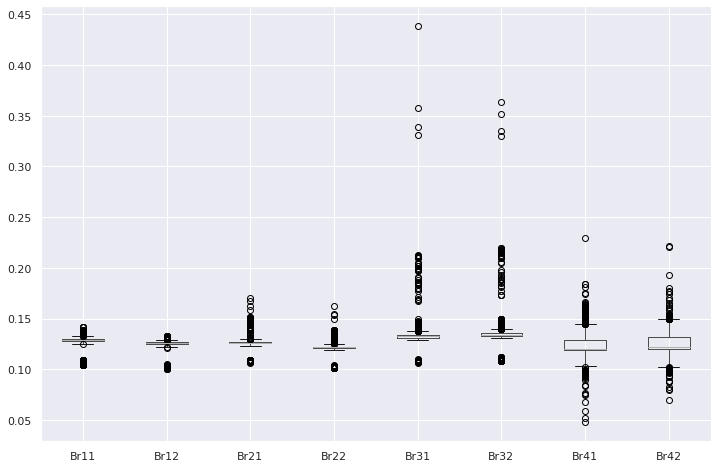

In [6]:
plt.figure(figsize = (12,8))

result_data.boxplot()

<AxesSubplot:>

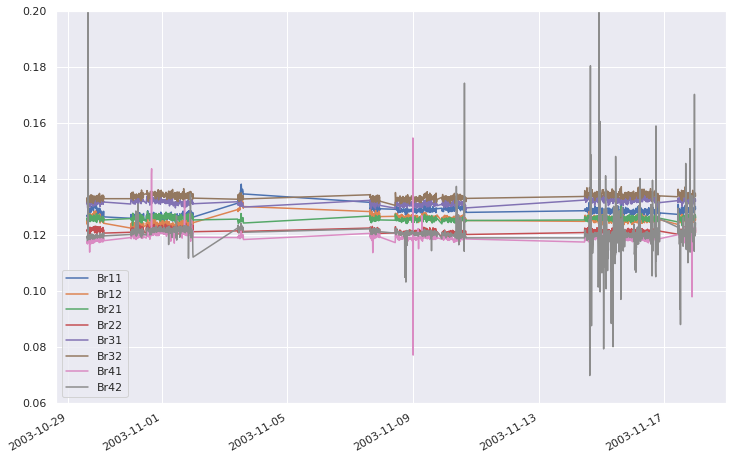

In [7]:
# prendo prima parte dati come train !!!
dataset_train = result_data['2003-10-25 00:00:01':'2003-11-17 23:59:00']
dataset_test = result_data['2003-11-17 23:59:00':]

# vibrazioni normali
dataset_train.plot(figsize = (12,8), ylim = (0.06, 0.2))

<AxesSubplot:>

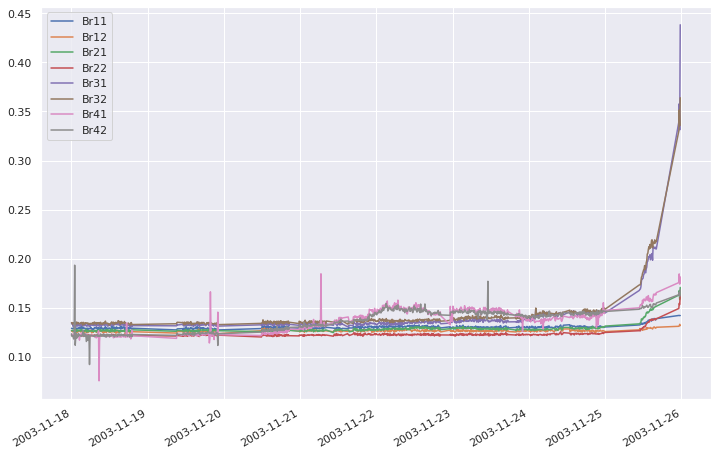

In [8]:
# come si vede da un certo punto le vibrazioni aumentano 
# e quelle di un cuscinetto "esplodono"
dataset_test.plot(figsize = (12,8))

In [9]:
# porto le feature sulla stessa scala...
scaler = preprocessing.MinMaxScaler()

# ovviamente lo scaler è addestrato soltanto sul training test
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns = dataset_train.columns, 
                       index = dataset_train.index)

# e lo stesso scaler è usato sul test set (non si devono contaminare)
X_test = pd.DataFrame(scaler.transform(dataset_test), columns = dataset_test.columns, 
                      index = dataset_test.index)

X = np.array(X_train)

* fin qui nulla di nuovo rispetto ad AutoEncoder

### PyOD
* usiamo **IsolationForest**

In [10]:
# in questo caso dobbiamo specificare la percentuale attesa di anomalie nel campione
clf1 = IForest(behaviour="new", max_samples=1160, contamination=0.01) 

In [11]:
clf1.fit(X)

IForest(behaviour='new', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples=1160, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [12]:
od_train_scores = clf1.decision_function(np.array(X_train))  # outlier scores

od_train_scores = pd.DataFrame(od_train_scores, index = X_train.index, columns = ['OUTSCORE'])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


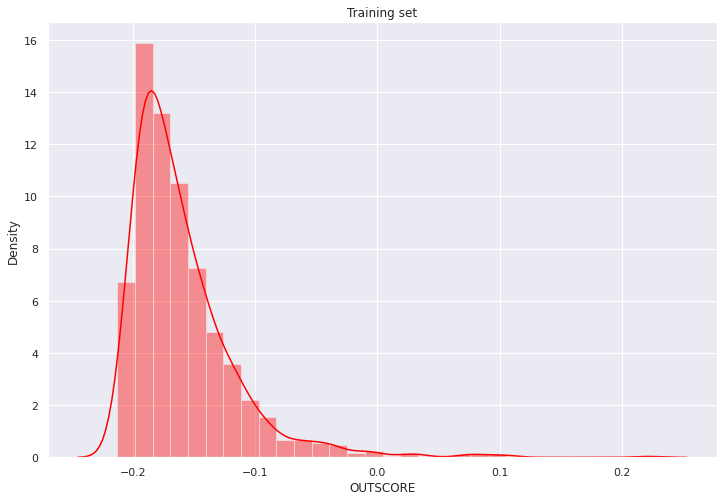

In [14]:
plt.figure(figsize = (12,8))

# disegno istogramma
plt.title('Training set')
sns.distplot(od_train_scores['OUTSCORE'], bins = 30, kde= True, color = 'red');

In [ ]:
# guardando ai due istogrammi
# possiamo scegliere 0 come soglia

In [15]:
od_test_scores = clf1.decision_function(np.array(X_test))  # outlier scores

od_test_scores = pd.DataFrame(od_test_scores, index = X_test.index, columns = ['OUTSCORE'])

/home/datascience/conda/tensorflow23_p37_gpu_v1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


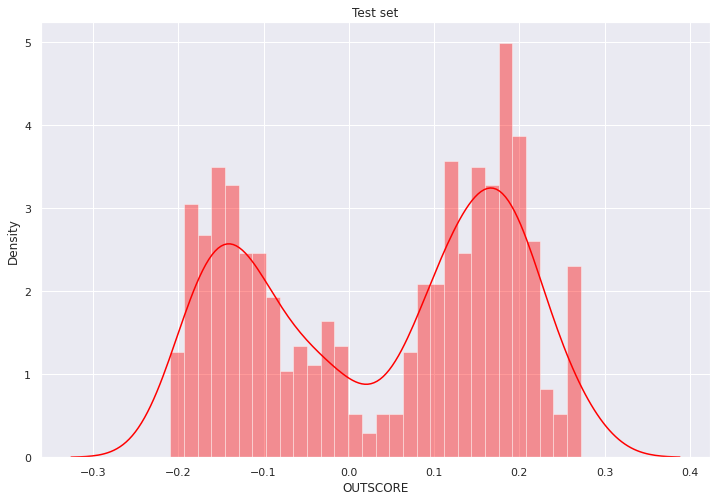

In [16]:
plt.figure(figsize = (12,8))

# disegno istogramma
plt.title('Test set')
sns.distplot(od_test_scores['OUTSCORE'], bins = 30, kde= True, color = 'red');

In [17]:
THRESHOLD = 0.
# prendiamo come soglia 0. (vedi grafico precedente)

od_test_scores['Threshold'] = THRESHOLD
od_test_scores['Anomaly'] = od_test_scores['OUTSCORE'] > od_test_scores['Threshold']

In [19]:
od_test_scores.tail(10)

,OUTSCORE,Threshold,Anomaly
2003-11-25 15:17:32,0.269132,0.0,True
2003-11-25 15:27:32,0.270413,0.0,True
2003-11-25 15:37:32,0.269132,0.0,True
2003-11-25 15:47:32,0.268280,0.0,True
2003-11-25 15:57:32,0.267002,0.0,True
2003-11-25 16:07:32,0.269132,0.0,True
2003-11-25 23:13:21,0.269559,0.0,True
2003-11-25 23:19:56,0.270413,0.0,True
2003-11-25 23:29:56,0.272124,0.0,True
2003-11-25 23:39:56,0.270413,0.0,True


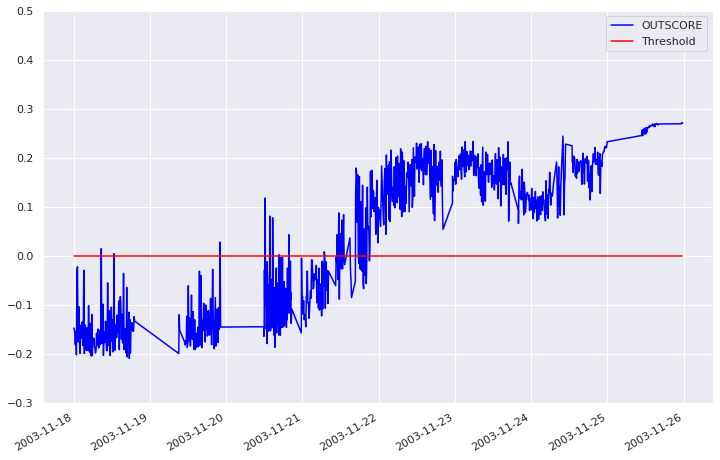

In [21]:
od_test_scores.plot(logy=False,  figsize = (12,8), ylim = [-0.3, 0.5], color = ['blue','red']);

### Anche qui riusciamo a prevedere il fault con più di 4 gg di anticipo